In [1]:
from __future__ import absolute_import, division, print_function
from __future__ import unicode_literals
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [63]:
import tensorflow as tf
import numpy as np
import copy
import tqdm
import IProgress
from hfunc import models
from hfunc import metrics
import time
import matplotlib.pyplot as plt

In [3]:
cifar = tf.keras.datasets.cifar10
class_accuracy = metrics.ClassAccuracy()

(x_train, y_train), (x_test, y_test) = cifar.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Converting interger values to floats (0 to 1)
y_train, y_test = tf.one_hot(y_train.flatten(), 10), tf.one_hot(y_test.flatten(), 10)
y_test_flat = np.argmax(y_test, axis=1)

In [4]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

In [5]:
tester_model2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
tester_model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

In [6]:
model2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=5)

Epoch 1/5
1563/1563 [==============================] - 6s 4ms/step - loss: 1.4364 - accuracy: 0.4804 - auc: 0.8799 - val_loss: 1.1864 - val_accuracy: 0.5812 - val_auc: 0.9204
Epoch 2/5
1563/1563 [==============================] - 5s 3ms/step - loss: 0.9800 - accuracy: 0.6536 - auc: 0.9453 - val_loss: 0.9751 - val_accuracy: 0.6523 - val_auc: 0.9458
Epoch 3/5
1563/1563 [==============================] - 5s 3ms/step - loss: 0.7919 - accuracy: 0.7200 - auc: 0.9637 - val_loss: 0.8467 - val_accuracy: 0.7039 - val_auc: 0.9586
Epoch 4/5
1563/1563 [==============================] - 5s 3ms/step - loss: 0.6572 - accuracy: 0.7705 - auc: 0.9745 - val_loss: 0.8780 - val_accuracy: 0.7068 - val_auc: 0.9555
Epoch 5/5
1563/1563 [==============================] - 5s 3ms/step - loss: 0.5452 - accuracy: 0.8091 - auc: 0.9818 - val_loss: 0.8190 - val_accuracy: 0.7279 - val_auc: 0.9614


In [7]:
model2.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.8190 - accuracy: 0.7279 - auc: 0.9614


[0.8190144896507263, 0.7279000282287598, 0.961372435092926]

In [12]:
model2.save_weights("C:\\Users\\Lucas\\Documents\\Masters\\models\\3-6-20\\model2.ckpt")

In [14]:
loss, acc, auc = model2.evaluate(x_test, y_test, verbose=2, batch_size=512)
original2 = model2.get_weights()
weight_len = len(original2) - 3
frac = 0.75
tol = -1e-5
ignore_tol = -1e-3
with open('results.txt', 'w') as f:
    for k in range(10):
        f.write(f"######### CLASS {k} #########\n")
        dense_layer_sizes = [64]
        conv_layer_sizes = [256, 128, 64, 32]
        conv_len = weight_len - 2 * len(dense_layer_sizes)
        bas2 = [acc]
        bls2 = [loss]
        best_weights = model2.get_weights()
        nodes_removed2 = []
        best_acc = 0
        best_loss = 1e20
        ol = loss
        num_removed2 = 0
        #amounts = []
        #places = []
        y_pred = model2.predict(x_test)
        y_pred_flat = np.argmax(y_pred, axis=1)
        y_pred_class = np.array([1 if y == k else 0 for y in y_pred_flat])
        y_test_class = np.array([1 if y == k else 0 for y in y_test_flat])

        oa = (y_pred_class == y_test_class).mean()
        for layer, size in enumerate(dense_layer_sizes):
            f.write(f"Layer {len(dense_layer_sizes+conv_layer_sizes) - layer}\n")
            end_not_reached = True
            num_removed2 = 0
            nodes_removed2 = []
            nodes_included = list(np.arange(size))
            current_pos = nodes_included[0]
            idx = 0
            print(f'Considering layer {len(dense_layer_sizes+conv_layer_sizes) - layer}')
            while end_not_reached:
                w = copy.deepcopy(best_weights)
                w[weight_len - (2*layer+1)][:,current_pos] = 0
                w[weight_len - 2*layer][current_pos] = 0
                tester_model2.set_weights(w)
                del w
                nl, na, nauc = tester_model2.evaluate(x_test, y_test, verbose=0, batch_size=1024)
                y_pred = tester_model2.predict(x_test)
                y_pred_flat = np.argmax(y_pred, axis=1)
                y_pred_class = np.array([1 if y == k else 0 for y in y_pred_flat])

                na = (y_pred_class == y_test_class).mean()
                # print(f"Node {current_pos}:", 0.*(na - oa) + 1.*(ol - nl))
                if frac*(na - oa) + (1.-frac)*(ol - nl) >= tol:
                    best_change = frac*(na - oa) + (1.-frac)*(ol - nl)
                    ol = nl
                    oa = na
                    size -= 1
                    dense_layer_sizes[layer] -= 1
                    nodes_removed2 += [current_pos]
                    nodes_included.remove(current_pos)
                    best_weights[weight_len - (2*layer+1)][:,current_pos] = 0
                    best_weights[weight_len - 2*layer][current_pos] = 0
                    num_removed2 += 1
                    #print("Improvement has occured!! Accuracy:", na, "--- Loss:", nl, '--- Change:', best_change, '--- New tol:', tol)
                    idx = 0
                elif frac*(na - oa) + (1.-frac)*(ol - nl) <= ignore_tol:  # Ignoring very important nodes
                    size -= 1
                    nodes_included.remove(current_pos)
                    idx += 1
                else:
                    idx += 1
                if idx >= size:
                    print("Layer optimized")
                    end_not_reached = False
                else:
                    current_pos = nodes_included[idx]
            f.write(f"Num nodes removed: {num_removed2}\n")
            f.write(f"Position of nodes removed: ")
            for p in nodes_removed2:
                f.write(f"{p}, ")
            f.write("\n")
            #amounts.append(num_removed2)
            #places.append(nodes_removed2)


        for layer, size in enumerate(conv_layer_sizes):
            f.write(f"Layer {len(conv_layer_sizes) - layer}\n")
            end_not_reached = True
            num_removed2 = 0
            nodes_removed2 = []
            nodes_included = list(np.arange(size))
            current_pos = nodes_included[0]
            idx = 0
            print(f'Considering layer {len(conv_layer_sizes) - layer}')
            while end_not_reached:
                w = copy.deepcopy(best_weights)
                w[conv_len - (2*layer+1)][:,:,:,current_pos] = 0
                w[conv_len - 2*layer][current_pos] = 0
                tester_model2.set_weights(w)
                del w
                nl, na, nauc = tester_model2.evaluate(x_test, y_test, verbose=0, batch_size=1024)
                y_pred = tester_model2.predict(x_test)
                y_pred_flat = np.argmax(y_pred, axis=1)
                y_pred_class = np.array([1 if y == k else 0 for y in y_pred_flat])

                na = (y_pred_class == y_test_class).mean()
                # print(f"Node {current_pos}:", 0.*(na - oa) + 1.*(ol - nl))
                if frac*(na - oa) + (1.-frac)*(ol - nl) >= tol:
                    best_change = frac*(na - oa) + (1.-frac)*(ol - nl)
                    ol = nl
                    oa = na
                    size -= 1
                    conv_layer_sizes[layer] -= 1
                    nodes_removed2 += [current_pos]
                    nodes_included.remove(current_pos)
                    best_weights[conv_len - (2*layer+1)][:,:,:,current_pos] = 0
                    best_weights[conv_len - 2*layer][current_pos] = 0
                    num_removed2 += 1
                    #print("Improvement has occured!! Accuracy:", na, "--- Loss:", nl, '--- Change:', best_change, '--- New tol:', tol)
                    idx = 0
                elif frac*(na - oa) + (1.-frac)*(ol - nl) <= ignore_tol:
                    size -= 1
                    nodes_included.remove(current_pos)
                    idx += 1
                else:
                    idx += 1
                if idx >= size:
                    print("Layer optimized")
                    end_not_reached = False
                else:
                    current_pos = nodes_included[idx]
            f.write(f"Num nodes removed: {num_removed2}\n")
            f.write(f"Position of nodes removed: ")
            for p in nodes_removed2:
                f.write(f"{p}, ")
            f.write("\n")
            #amounts.append(num_removed2)
            #places.append(nodes_removed2)
        
end = time.time()
tester_model2.set_weights(best_weights)

20/20 - 0s - loss: 0.8190 - accuracy: 0.7279 - auc: 0.9614
Considering layer 5
Layer optimized
Considering layer 4
Layer optimized
Considering layer 3
Layer optimized
Considering layer 2
Layer optimized
Considering layer 1
Layer optimized
Considering layer 5
Layer optimized
Considering layer 4
Layer optimized
Considering layer 3
Layer optimized
Considering layer 2
Layer optimized
Considering layer 1
Layer optimized
Considering layer 5
Layer optimized
Considering layer 4
Layer optimized
Considering layer 3
Layer optimized
Considering layer 2
Layer optimized
Considering layer 1
Layer optimized
Considering layer 5
Layer optimized
Considering layer 4
Layer optimized
Considering layer 3
Layer optimized
Considering layer 2
Layer optimized
Considering layer 1
Layer optimized
Considering layer 5
Layer optimized
Considering layer 4
Layer optimized
Considering layer 3
Layer optimized
Considering layer 2
Layer optimized
Considering layer 1
Layer optimized
Considering layer 5
Layer optimized
Consi

In [15]:
fp = tf.keras.metrics.FalsePositives()
tp = tf.keras.metrics.TruePositives()

y_pred = tester_model2.predict(x_test)
y_pred_flat = np.argmax(y_pred, axis=1)
y_pred_class_5 = [1 if y == 4 else 0 for y in y_pred_flat]
y_test_class_5 = [1 if y == 4 else 0 for y in y_test_flat]

fp.update_state(y_test_class_5, y_pred_class_5)
tp.update_state(y_test_class_5, y_pred_class_5)

print(fp.result().numpy())
print(tp.result().numpy())

355.0
697.0


In [16]:
fp = tf.keras.metrics.FalsePositives()
tp = tf.keras.metrics.TruePositives()

y_pred = model2.predict(x_test)
y_pred_flat = np.argmax(y_pred, axis=1)
y_pred_class_5 = np.array([1 if y == 4 else 0 for y in y_pred_flat])
y_test_class_5 = np.array([1 if y == 4 else 0 for y in y_test_flat])


fp.update_state(y_test_class_5, y_pred_class_5)
tp.update_state(y_test_class_5, y_pred_class_5)

print(fp.result().numpy())
print(tp.result().numpy())

325.0
696.0


In [17]:
y_pred = model2.predict(x_test)
K = len(set(y_test_flat))
yp = tf.argmax(y_pred, axis=1)
acc = []
for i in range(K):
    a = np.mean((yp[y_test_flat == i] == y_test_flat[y_test_flat == i]).numpy())
    acc.append(a)
accuracies = tf.convert_to_tensor(acc)
print(acc)

[0.821, 0.822, 0.608, 0.55, 0.696, 0.694, 0.754, 0.748, 0.784, 0.802]


In [18]:
y_pred = tester_model2.predict(x_test)
K = len(set(y_test_flat))
yp = tf.argmax(y_pred, axis=1)
acc = []
for i in range(K):
    a = np.mean((yp[y_test_flat == i] == y_test_flat[y_test_flat == i]).numpy())
    acc.append(a)
accuracies = tf.convert_to_tensor(acc)
print(acc)

[0.786, 0.861, 0.617, 0.588, 0.697, 0.523, 0.808, 0.768, 0.841, 0.808]


# Class Specific removals

In [29]:
lines = []
with open("results.txt") as f:
    for line in f:
        line = line.strip()
        lines.append(line)

In [40]:
lines

['######### CLASS 0 #########',
 'Layer 5',
 'Num nodes removed: 45',
 'Position of nodes removed: 4, 1, 3, 7, 6, 8, 11, 10, 12, 15, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 27, 29, 30, 31, 34, 36, 35, 37, 38, 47, 44, 42, 51, 52, 50, 55, 54, 56, 57, 58, 59, 60, 61,',
 'Layer 4',
 'Num nodes removed: 104',
 'Position of nodes removed: 0, 5, 7, 8, 10, 11, 14, 20, 27, 28, 29, 25, 32, 34, 19, 22, 35, 37, 39, 6, 40, 43, 44, 48, 30, 21, 18, 36, 33, 1, 50, 52, 67, 58, 78, 79, 87, 90, 92, 9, 4, 12, 63, 66, 74, 95, 103, 98, 105, 116, 119, 16, 62, 84, 118, 60, 113, 121, 47, 51, 104, 101, 125, 126, 128, 132, 136, 137, 139, 148, 149, 151, 152, 159, 167, 168, 171, 170, 176, 175, 177, 182, 190, 191, 193, 194, 195, 197, 201, 203, 211, 209, 217, 218, 42, 76, 187, 220, 226, 231, 233, 245, 240, 246,',
 'Layer 3',
 'Num nodes removed: 36',
 'Position of nodes removed: 0, 1, 2, 11, 13, 8, 12, 16, 15, 19, 21, 20, 22, 28, 32, 34, 39, 46, 40, 42, 58, 55, 50, 80, 64, 79, 82, 84, 88, 94, 93, 91, 101, 11

In [35]:
lines[2][19:]

'45'

In [37]:
lines[3][27:]

'4, 1, 3, 7, 6, 8, 11, 10, 12, 15, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 27, 29, 30, 31, 34, 36, 35, 37, 38, 47, 44, 42, 51, 52, 50, 55, 54, 56, 57, 58, 59, 60, 61,'

In [39]:
lines[3][27:].replace(",", "").split()

['4',
 '1',
 '3',
 '7',
 '6',
 '8',
 '11',
 '10',
 '12',
 '15',
 '14',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '28',
 '27',
 '29',
 '30',
 '31',
 '34',
 '36',
 '35',
 '37',
 '38',
 '47',
 '44',
 '42',
 '51',
 '52',
 '50',
 '55',
 '54',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61']

In [57]:
rem_dict = {}
ltc = [2, 3, 5, 6, 8, 9, 11, 12, 14, 15]
for k in range(10):
    am = []
    pl = []
    for i, line in enumerate(ltc):
        line = line + 16*k
        if i % 2 == 0:
            am.append(int(lines[line][19:]))
        else:
            pl.append(list(map(int, lines[line][27:].replace(",", "").split())))
    rem_dict[f"class_{k}"] = [am, pl]

In [ ]:
plt.scatter(np.arange(64))

In [61]:
a = np.zeros(64)
a[rem_dict["class_0"][1][0]] = 1
a

array([0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.])

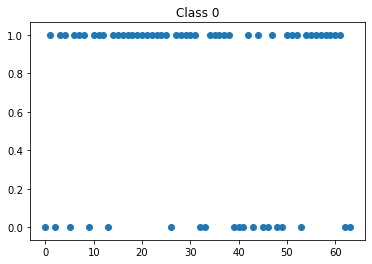

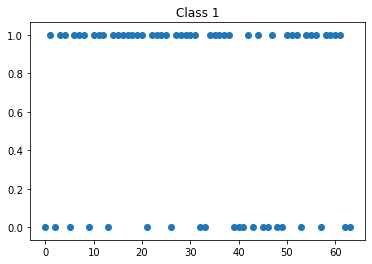

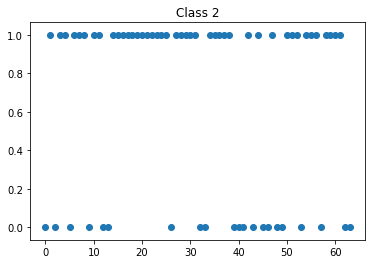

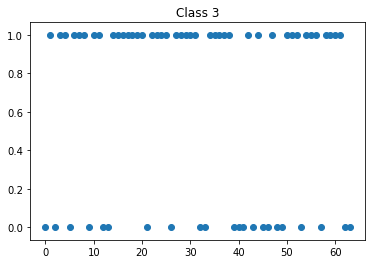

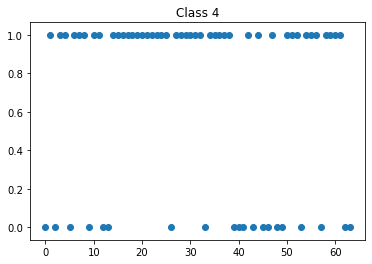

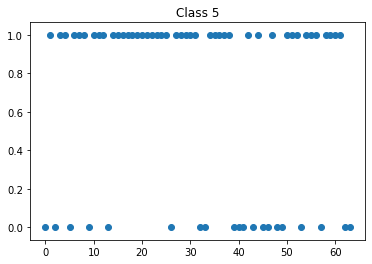

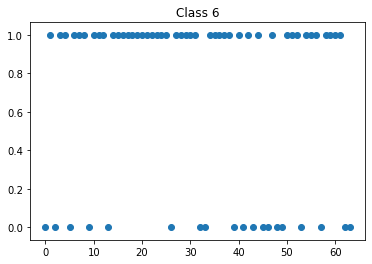

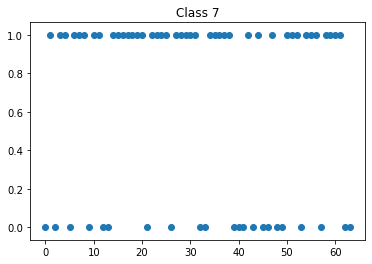

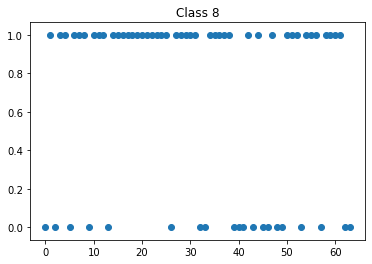

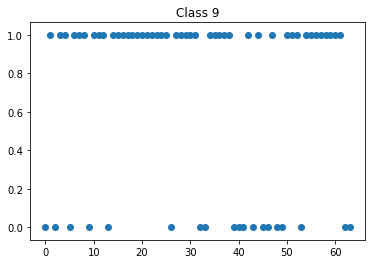

In [80]:
layer = 5
layer_size = 64
for k in range(10):
    a = np.zeros(layer_size)
    a[rem_dict[f"class_{k}"][1][5-layer]] = 1
    plt.scatter(np.arange(layer_size), a)
    plt.title(f"Class {k}")
    plt.show()